In [37]:
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import nasdaqdatalink
import quantstats as qs
from scipy import interpolate
from scipy import ndimage
import datetime as dt
import bt

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

In [3]:
%run ./NasdaqKey.ipynb

In [4]:
nasdaqdatalink.ApiConfig.api_key = API_KEY

Data from https://www.cboe.com/tradable_products/vix/vix_historical_data/

In [5]:
mydata = nasdaqdatalink.get_table('SCF/PRICES', quandl_code='CBOE_VX1_EN')

In [6]:
mydata[['date','settle']].sort_values('date').reset_index(drop=True)

date   settle
0    2017-01-03  13.7750
1    2017-01-04  13.1750
2    2017-01-05  13.0250
3    2017-01-06  12.8750
4    2017-01-09  12.9250
...         ...      ...
1268 2022-01-13  20.4167
1269 2022-01-14  19.6670
1270 2022-01-18  22.6197
1271 2022-01-19  22.7900
1272 2022-01-20  24.9658

[1273 rows x 2 columns]

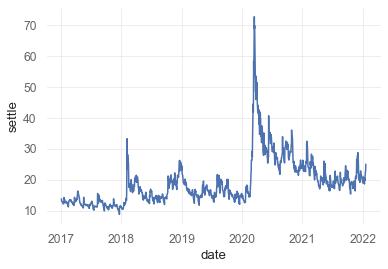

In [7]:
sns.lineplot(data=mydata, x='date',y='settle')
plt.show()

In [8]:
fig = px.line(data_frame=mydata, x='date', y='settle')
fig.show()

### Checking downside correlation of VIX and S&P500 

In [9]:
tickers = yf.Tickers('^gspc ^vix')

In [10]:
df = tickers.history(period='max')
df.dropna(how='any', axis=0, inplace=True)

[*********************100%***********************]  2 of 2 completed


In [11]:
df['logRets']= 0

In [12]:
cols = list(df['Close'].columns)

for col in cols:
    df['logRets', col] = np.log(df['Close', col]/df['Close', col].shift())

In [13]:
df

Close            Dividends              High             \
                  ^GSPC       ^VIX     ^GSPC ^VIX        ^GSPC       ^VIX   
Date                                                                        
1990-01-02   359.690002  17.240000         0  0.0   359.690002  17.240000   
1990-01-03   358.760010  18.190001         0  0.0   360.589996  18.190001   
1990-01-04   355.670013  19.219999         0  0.0   358.760010  19.219999   
1990-01-05   352.200012  20.110001         0  0.0   355.670013  20.110001   
1990-01-08   353.790009  20.260000         0  0.0   354.239990  20.260000   
...                 ...        ...       ...  ...          ...        ...   
2022-01-14  4662.850098  19.190001         0  0.0  4665.129883  22.070000   
2022-01-18  4577.109863  22.790001         0  0.0  4632.240234  23.200001   
2022-01-19  4532.759766  23.850000         0  0.0  4611.549805  23.990000   
2022-01-20  4482.729980  25.590000         0  0.0  4602.109863  25.889999   
2022-01-21  4397.939941  28.850000         0  0.0  4494.520020  29.790001   

                    Low                    Open            Stock Splits       \
                  ^GSPC       ^VIX        ^GSPC       ^VIX        ^GSPC ^VIX   
Date                                                                           
1990-01-02   351.980011  17.240000   353.399994  17.240000            0  0.0   
1990-01-03   357.890015  18.190001   359.690002  18.190001            0  0.0   
1990-01-04   352.890015  19.219999   358.760010  19.219999            0  0.0   
1990-01-05   351.350006  20.110001   355.670013  20.110001            0  0.0   
1990-01-08   350.540009  20.260000   352.200012  20.260000            0  0.0   
...                 ...        ...          ...        ...          ...  ...   
2022-01-14  4614.750000  19.049999  4637.990234  20.110001            0  0.0   
2022-01-18  4568.700195  21.180000  4632.240234  21.180000            0  0.0   
2022-01-19  4530.200195  21.850000  4588.029785  23.120001            0  0.0   
2022-01-20  4477.950195  21.680000  4547.350098  23.459999            0  0.0   
2022-01-21  4395.339844  25.309999  4471.379883  25.379999            0  0.0   

                Volume      logRets                      
                 ^GSPC ^VIX             ^GSPC      ^VIX  
Date                                                     
1990-01-02   162070000  0.0       0       NaN       NaN  
1990-01-03   192330000  0.0       0 -0.002589  0.053640  
1990-01-04   177000000  0.0       0 -0.008650  0.055079  
1990-01-05   158530000  0.0       0 -0.009804  0.045266  
1990-01-08   140110000  0.0       0  0.004504  0.007431  
...                ...  ...     ...       ...       ...  
2022-01-14  3483530000  0.0       0  0.000820 -0.056724  
2022-01-18  3324960000  0.0       0 -0.018559  0.171933  
2022-01-19  3387370000  0.0       0 -0.009737  0.045462  
2022-01-20  3473060000  0.0       0 -0.011099  0.070417  
2022-01-21  3945810000  0.0       0 -0.019096  0.119908  

[7987 rows x 17 columns]

#### Scatter plot for different frequencies

In [14]:
df.dropna(how='any', axis=0, inplace=True)
df = df.drop('', axis=1, level=1)
daily_df = df
weekly_df = df.resample('W').sum()
monthly_df = df.resample('BM').sum()

In [15]:
fig = go.Figure()

for col in daily_df['logRets']:
    fig.add_scatter(x=daily_df.index, y=daily_df['logRets', col], name=col)
    
fig.update_layout(
    title=f"Daily log returns for {daily_df.index[0].strftime('%B %Y')} - " \
          +                f"{daily_df.index[-1].strftime('%B %Y')}"
)

fig.show()

In [16]:
fig = px.scatter(data_frame=daily_df['logRets'], x='^GSPC', y='^VIX')
fig.show()

In [17]:
fig = go.Figure()

fig = go.Figure(data=go.Scatter(x=df['logRets', '^GSPC'], y=df['logRets', '^VIX'], mode='markers'))

fig.show()

In [18]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Daily", "Weekly", "Monthly"))

fig.add_trace(
    go.Scatter(x=daily_df['logRets', '^GSPC'], y=daily_df['logRets', '^VIX'], mode='markers', name='Daily',
               hovertext=list(daily_df.index),
               hovertemplate = '<b>^VIX</b>: %{y:.2%}'+ '<br><b>^GSPC</b>: %{x:.2%}'+ '<br><b>Date</b>: %{hovertext}',),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=weekly_df['logRets', '^GSPC'], y=weekly_df['logRets', '^VIX'], mode='markers', name='Weekly',
               hovertext=list(weekly_df.index),
               hovertemplate = '<b>^VIX</b>: %{y:.2%}'+ '<br><b>^GSPC</b>: %{x:.2%}'+ '<br><b>Date</b>: %{hovertext}',),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=monthly_df['logRets', '^GSPC'], y=monthly_df['logRets', '^VIX'], mode='markers', name='Monthly',
               hovertext=list(monthly_df.index),
               hovertemplate = '<b>^VIX</b>: %{y:.2%}'+ '<br><b>^GSPC</b>: %{x:.2%}'+ '<br><b>Date</b>: %{hovertext}',),
    row=3, col=1
)

fig.update_layout(height=1000, width=1000, title_text="Log Returns of VIX vs SPX by frequency (D/W/M)")
fig.show()

#### Downside correlations

In [19]:
daily_df[daily_df['logRets', '^GSPC'] < 0]['logRets'].corr()

^GSPC      ^VIX
^GSPC  1.000000 -0.595156
^VIX  -0.595156  1.000000

In [20]:
weekly_df[weekly_df['logRets', '^GSPC'] < 0]['logRets'].corr()

^GSPC      ^VIX
^GSPC  1.000000 -0.537031
^VIX  -0.537031  1.000000

In [21]:
monthly_df[monthly_df['logRets', '^GSPC'] < 0]['logRets'].corr()

^GSPC      ^VIX
^GSPC  1.000000 -0.462125
^VIX  -0.462125  1.000000

#### Upside correlations

In [22]:
daily_df[daily_df['logRets', '^GSPC'] > 0]['logRets'].corr()

^GSPC      ^VIX
^GSPC  1.000000 -0.468528
^VIX  -0.468528  1.000000

In [23]:
weekly_df[weekly_df['logRets', '^GSPC'] > 0]['logRets'].corr()

^GSPC      ^VIX
^GSPC  1.000000 -0.455367
^VIX  -0.455367  1.000000

In [24]:
monthly_df[monthly_df['logRets', '^GSPC'] > 0]['logRets'].corr()

^GSPC      ^VIX
^GSPC  1.000000 -0.394386
^VIX  -0.394386  1.000000

Bottom line: less negative correlation when SPX up than when SPX down

In [25]:
dfs = [daily_df, weekly_df, monthly_df]
freq = ['Daily', 'Weekly', 'Monthly']

for i, dataframe in enumerate(dfs):
    mean_gspc = dataframe[dataframe['logRets', '^GSPC'] > 0]['logRets'].mean().loc['^GSPC']
    mean_vix = dataframe[dataframe['logRets', '^GSPC'] > 0]['logRets'].mean().loc['^VIX']
    print("%s mean positive log returns of GSPC is: %.3f, mean log returns of VIX are %.2f" % (freq[i], mean_gspc, mean_vix))

Daily mean positive log returns of GSPC is: 0.007, mean log returns of VIX are -0.04
Weekly mean positive log returns of GSPC is: 0.016, mean log returns of VIX are -0.07
Monthly mean positive log returns of GSPC is: 0.031, mean log returns of VIX are -0.09


In [26]:
dfs = [daily_df, weekly_df, monthly_df]
freq = ['Daily', 'Weekly', 'Monthly']

for i, dataframe in enumerate(dfs):
    mean_gspc = dataframe[dataframe['logRets', '^GSPC'] < 0]['logRets'].mean().loc['^GSPC']
    mean_vix = dataframe[dataframe['logRets', '^GSPC'] < 0]['logRets'].mean().loc['^VIX']
    print("%s mean negative log returns of GSPC is: %.3f, mean log returns of VIX are %.2f" % (freq[i], mean_gspc, mean_vix))

Daily mean negative log returns of GSPC is: -0.008, mean log returns of VIX are 0.04
Weekly mean negative log returns of GSPC is: -0.017, mean log returns of VIX are 0.09
Monthly mean negative log returns of GSPC is: -0.037, mean log returns of VIX are 0.16


## Building VIX Signals
https://medium.datadriveninvestor.com/how-to-harness-the-power-of-vix-to-protect-your-portfolio-part-3-bbfa12ba7c38

In [27]:
### Getting front-month and first back-month continuous futures price series on VIX
nasdaqData = nasdaqdatalink.get_table('SCF/PRICES', quandl_code=['CBOE_VX1_EN', 'CBOE_VX2_EN'])


In [28]:
futures_df = nasdaqData[['quandl_code', 'date', 'settle']]

In [29]:
### Clean both series and merge

VX1 = futures_df[futures_df['quandl_code'] == 'CBOE_VX1_EN']
VX1 = VX1.set_index('date', drop=True)
VX1 = VX1.rename(columns={'settle':'VX1'})
VX1 = VX1.drop(columns='quandl_code')

VX2 = futures_df[futures_df['quandl_code'] == 'CBOE_VX2_EN']
VX2 = VX2.set_index('date', drop=True)
VX2 = VX2.rename(columns={'settle':'VX2'})
VX2 = VX2.drop(columns='quandl_code')

VIX_futures = VX1.join([VX2], how='left')
VIX_futures = VIX_futures.sort_index()

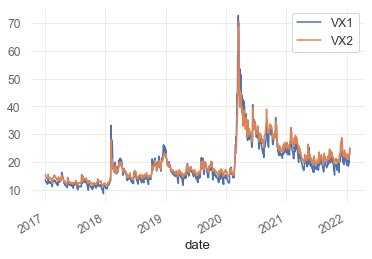

In [30]:
VIX_futures.plot()
plt.show()

In [31]:
tickers = yf.Tickers('^gspc ^vix ^vix3m')
df = tickers.history(period='max')

df['logRets']= 0
cols = list(df['Close'].columns)

for col in cols:
    df['logRets', col] = np.log(df['Close', col]/df['Close', col].shift())

df.dropna(how='any', axis=0, inplace=True)
df = df.drop('', axis=1, level=1)

[*********************100%***********************]  3 of 3 completed


In [32]:
close_df = df['Close'].join([VIX_futures], how='left')
close_df = close_df.dropna(how='any', axis=0)

In [33]:
close_df

^GSPC       ^VIX     ^VIX3M      VX1      VX2
Date                                                           
2017-01-03  2257.830078  12.850000  15.560000  13.7750  15.5750
2017-01-04  2270.750000  11.850000  14.840000  13.1750  14.9750
2017-01-05  2269.000000  11.670000  14.700000  13.0250  14.8250
2017-01-06  2276.979980  11.320000  14.560000  12.8750  14.6750
2017-01-09  2268.899902  11.560000  14.630000  12.9250  14.5250
...                 ...        ...        ...      ...      ...
2022-01-13  4659.029785  20.309999  23.410000  20.4167  22.0944
2022-01-14  4662.850098  19.190001  22.820000  19.6670  21.7462
2022-01-18  4577.109863  22.790001  25.120001  22.6197  23.3922
2022-01-19  4532.759766  23.850000  25.809999  22.7900  24.0687
2022-01-20  4482.729980  25.590000  27.250000  24.9658  25.1061

[1272 rows x 5 columns]

In [34]:
### VRatio = VIX3M / VIX
close_df['VRatio'] = close_df['^VIX3M']/close_df['^VIX']

### Contango
close_df['Contango'] = close_df['VX2']/close_df['VX1'] - 1

### Contango Roll
close_df['ContangoRoll'] = close_df['VX2']/close_df['^VIX'] - 1

### VRP
close_df['HV5'] = close_df['^GSPC'].rolling(5).std()
close_df['HV10'] = close_df['^GSPC'].rolling(10).std()

close_df['VRP5'] = close_df['^VIX'] - close_df['HV5']
close_df['VRP10'] = close_df['^VIX'] - close_df['HV10']

### Fast VRP
close_df['EMA7_VIX'] = close_df['^VIX'].ewm(span=7, adjust=False).mean()
close_df['FVRP'] = close_df['EMA7_VIX'] - close_df['HV5']

### VIX Momemtum
close_df['SMA50_VIX'] = close_df['^VIX'].rolling(50).mean()
close_df['VOLMOM'] = close_df['SMA50_VIX'] - close_df['^VIX']

### VIX Mean Reversion
close_df['MRVIX'] = (close_df['^VIX'] < 12) & (close_df['^VIX'] < 20)

### VIX3M Mean Reversion
close_df['MRVIX3M'] = (close_df['^VIX'] < 12) & (close_df['^VIX3M'] < 20)

In [35]:
close_df = close_df.dropna(how='any', axis=0)

In [36]:
close_df

^GSPC       ^VIX     ^VIX3M      VX1      VX2    VRatio  \
Date                                                                        
2017-03-15  2385.260010  11.630000  14.200000  12.2750  13.7250  1.220980   
2017-03-16  2381.379883  11.210000  13.780000  11.9250  13.2750  1.229260   
2017-03-17  2378.250000  11.280000  13.920000  11.7750  13.2750  1.234043   
2017-03-20  2373.469971  11.340000  13.900000  11.6250  13.1750  1.225750   
2017-03-21  2344.020020  12.470000  14.620000  12.1750  13.7750  1.172414   
...                 ...        ...        ...      ...      ...       ...   
2022-01-13  4659.029785  20.309999  23.410000  20.4167  22.0944  1.152634   
2022-01-14  4662.850098  19.190001  22.820000  19.6670  21.7462  1.189161   
2022-01-18  4577.109863  22.790001  25.120001  22.6197  23.3922  1.102238   
2022-01-19  4532.759766  23.850000  25.809999  22.7900  24.0687  1.082180   
2022-01-20  4482.729980  25.590000  27.250000  24.9658  25.1061  1.064869   

            Contango  ContangoRoll        HV5       HV10       VRP5  \
Date                                                                  
2017-03-15  0.118126      0.180138   8.239274   8.038955   3.390726   
2017-03-16  0.113208      0.184211   7.798680   7.976461   3.411320   
2017-03-17  0.127389      0.176862   7.657595   7.439727   3.622404   
2017-03-20  0.133333      0.161817   7.657595   7.393248   3.682405   
2017-03-21  0.131417      0.104651  16.483173  11.701028  -4.013172   
...              ...           ...        ...        ...        ...   
2022-01-13  0.082173      0.087858  29.007888  49.973323  -8.697888   
2022-01-14  0.105720      0.133205  31.106726  50.016113 -11.916725   
2022-01-18  0.034152      0.026424  58.744192  55.439360 -35.954191   
2022-01-19  0.056108      0.009170  76.558977  61.108309 -52.708976   
2022-01-20  0.005620     -0.018910  78.691429  81.171164 -53.101429   

                VRP10   EMA7_VIX       FVRP  SMA50_VIX    VOLMOM  MRVIX  \
Date                                                                      
2017-03-15   3.591045  11.779773   3.540499    11.6070 -0.023000   True   
2017-03-16   3.233539  11.637330   3.838650    11.5742  0.364200   True   
2017-03-17   3.840272  11.547997   3.890402    11.5628  0.282800   True   
2017-03-20   3.946752  11.495998   3.838403    11.5562  0.216200   True   
2017-03-21   0.768972  11.739499  -4.743674    11.5792 -0.890800  False   
...               ...        ...        ...        ...       ...    ...   
2022-01-13 -29.663324  18.868624 -10.139264    19.8644 -0.445599  False   
2022-01-14 -30.826112  18.948968 -12.157758    19.9462  0.756200  False   
2022-01-18 -32.649359  19.909226 -38.834965    20.0932 -2.696801  False   
2022-01-19 -37.258309  20.894420 -55.664557    20.2406 -3.609400  False   
2022-01-20 -55.581164  22.068315 -56.623114    20.4080 -5.182000  False   

            MRVIX3M  
Date                 
2017-03-15     True  
2017-03-16     True  
2017-03-17     True  
2017-03-20     True  
2017-03-21    False  
...             ...  
2022-01-13    False  
2022-01-14    False  
2022-01-18    False  
2022-01-19    False  
2022-01-20    False  

[1223 rows x 18 columns]

## Running backtest based on signals

#### Rules
- VRatio > 1 => Risk-On
- Contango > -5% => Risk-On
- Contango Roll > 10% => Risk-On
- VRP > 0 => Risk-On
- FVRP > 0 => Risk-On
- Vol Momentum > 0 => Risk-On
- VIX Mean Reversion > 12 and < 20 => Risk-On
- VIX3M Mean Reversion > 12 and < 20 => Risk-On


### Testing S&P500 B&H backtest

In [40]:
test_df = close_df[['^GSPC', '^VIX']].copy(deep=True)

In [42]:
test_df['^VIX'] = test_df['^VIX']*0

In [60]:
s = bt.Strategy('SP500', [bt.algos.SelectWhere(test_df > 0),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

t = bt.Backtest(s, close_df)
res= bt.run(t)

In [61]:
res.display()

Stat                 SP500
-------------------  ----------
Start                2017-03-14
End                  2022-01-20
Risk-free rate       0.00%

Total Return         87.88%
Daily Sharpe         0.76
Daily Sortino        1.13
CAGR                 13.87%
Max Drawdown         -33.91%
Calmar Ratio         0.41

MTD                  -5.95%
3m                   -1.18%
6m                   3.69%
YTD                  -5.95%
1Y                   16.37%
3Y (ann.)            19.43%
5Y (ann.)            13.87%
10Y (ann.)           -
Since Incep. (ann.)  13.87%

Daily Sharpe         0.76
Daily Sortino        1.13
Daily Mean (ann.)    14.92%
Daily Vol (ann.)     19.53%
Daily Skew           -0.72
Daily Kurt           19.64
Best Day             9.38%
Worst Day            -11.98%

Monthly Sharpe       0.91
Monthly Sortino      1.54
Monthly Mean (ann.)  14.58%
Monthly Vol (ann.)   15.95%
Monthly Skew         -0.56
Monthly Kurt         1.26
Best Month           12.68%
Worst Month          -12.51%



<AxesSubplot:title={'center':'Equity Progression'}>

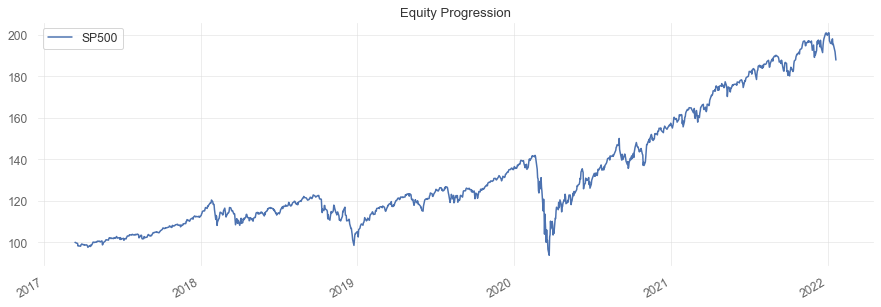

In [64]:
res.plot()

In [77]:
res.prices

SP500
2017-03-14  100.000000
2017-03-15  100.000000
2017-03-16   99.837423
2017-03-17   99.706281
2017-03-20   99.505997
...                ...
2022-01-13  195.270954
2022-01-14  195.431025
2022-01-18  191.838509
2022-01-19  189.980240
2022-01-20  187.883992

[1224 rows x 1 columns]

### Contango
Trying backtest with risk-off assets:
- UST
- IG US Corps
- Gold

In [121]:
tickers = yf.Tickers('spy ief lqd gld')

In [149]:
df = tickers.history(period='5Y')

[*********************100%***********************]  4 of 4 completed


In [150]:
signals = ['VRatio', 'Contango', 'ContangoRoll', 'VRP5', 'VRP10', 'FVRP', 'VOLMOM', 'MRVIX', 'MRVIX3M']

df = df['Close']
df = df.join([close_df[signals]], how='left')
df[signals] = df[signals].shift()
df = df.dropna(how='any', axis=0)

In [124]:
signals_df = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_df=signals_df*0
signals_df['LQD'] = np.where(df['Contango'] > -0.05, False, True)
signals_df['IEF'] = np.where(df['Contango'] > -0.05, False, True)
signals_df['GLD'] = np.where(df['Contango'] > -0.05, False, True)
signals_df['SPY'] = np.where(df['Contango'] > -0.05, True, False)

In [125]:
signals_df2 = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_df2=signals_df2*0
signals_df2['LQD'] = False
signals_df2['IEF'] = False
signals_df2['GLD'] = False
signals_df2['SPY'] = True

In [127]:
s1 = bt.Strategy('SP500', [bt.algos.SelectWhere(signals_df2),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

s2 = bt.Strategy('Contango', [bt.algos.SelectWhere(signals_df),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

t1 = bt.Backtest(s1, df)
t2 = bt.Backtest(s2, df)
res= bt.run(t1,t2)

In [128]:
res.display()

Stat                 SP500       Contango
-------------------  ----------  ----------
Start                2017-03-15  2017-03-15
End                  2022-01-21  2022-01-21
Risk-free rate       0.00%       0.00%

Total Return         100.65%     99.29%
Daily Sharpe         0.84        1.08
Daily Sortino        1.25        1.62
CAGR                 15.43%      15.26%
Max Drawdown         -33.71%     -20.71%
Calmar Ratio         0.46        0.74

MTD                  -7.79%      -7.79%
3m                   -3.10%      -3.10%
6m                   1.47%       1.47%
YTD                  -7.79%      -7.79%
1Y                   15.50%      15.66%
3Y (ann.)            20.58%      21.53%
5Y (ann.)            15.43%      15.26%
10Y (ann.)           -           -
Since Incep. (ann.)  15.43%      15.26%

Daily Sharpe         0.84        1.08
Daily Sortino        1.25        1.62
Daily Mean (ann.)    16.20%      15.20%
Daily Vol (ann.)     19.18%      14.05%
Daily Skew           -0.76       -0.91


<AxesSubplot:title={'center':'Equity Progression'}>

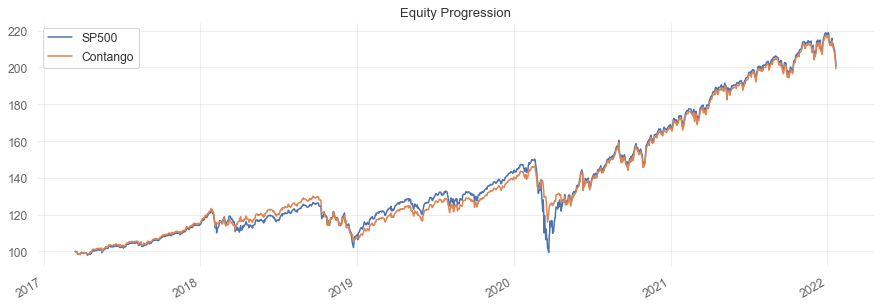

In [130]:
res.plot()

In [138]:
### Checking correlations over the period, IG Corp doesn't look great for risk-off
logRets_df = np.log(df[['SPY', 'IEF', 'GLD', 'LQD']].div(df[['SPY', 'IEF', 'GLD', 'LQD']].shift())).dropna()
logRets_df.corr()

SPY       IEF       GLD       LQD
SPY  1.000000 -0.389631  0.060843  0.259124
IEF -0.389631  1.000000  0.342341  0.498616
GLD  0.060843  0.342341  1.000000  0.317791
LQD  0.259124  0.498616  0.317791  1.000000

In [142]:
### Especially when SPY is down

logRets_df[logRets_df['SPY']<0].corr()

SPY       IEF       GLD       LQD
SPY  1.000000 -0.324549  0.054318  0.331337
IEF -0.324549  1.000000  0.338444  0.556823
GLD  0.054318  0.338444  1.000000  0.378184
LQD  0.331337  0.556823  0.378184  1.000000

In [144]:
signals_df3 = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_df3=signals_df3*0
signals_df3['LQD'] = False
signals_df3['IEF'] = np.where(df['Contango'] > -0.05, False, True)
signals_df3['GLD'] = np.where(df['Contango'] > -0.05, False, True)
signals_df3['SPY'] = np.where(df['Contango'] > -0.05, True, False)

In [145]:
s3 = bt.Strategy('Contango v2', [bt.algos.SelectWhere(signals_df3),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

t3 = bt.Backtest(s3, df)
res= bt.run(t1,t2,t3)

In [146]:
### Slight improvement in terms of drawdowns/vols

res.display()

Stat                 SP500       Contango    Contango v2
-------------------  ----------  ----------  -------------
Start                2017-03-15  2017-03-15  2017-03-15
End                  2022-01-21  2022-01-21  2022-01-21
Risk-free rate       0.00%       0.00%       0.00%

Total Return         100.65%     99.29%      105.23%
Daily Sharpe         0.84        1.08        1.14
Daily Sortino        1.25        1.62        1.70
CAGR                 15.43%      15.26%      15.96%
Max Drawdown         -33.71%     -20.71%     -18.23%
Calmar Ratio         0.46        0.74        0.88

MTD                  -7.79%      -7.79%      -7.78%
3m                   -3.10%      -3.10%      -3.10%
6m                   1.47%       1.47%       1.47%
YTD                  -7.79%      -7.79%      -7.78%
1Y                   15.50%      15.66%      15.65%
3Y (ann.)            20.58%      21.53%      22.38%
5Y (ann.)            15.43%      15.26%      15.96%
10Y (ann.)           -           -           -
S

<AxesSubplot:title={'center':'Equity Progression'}>

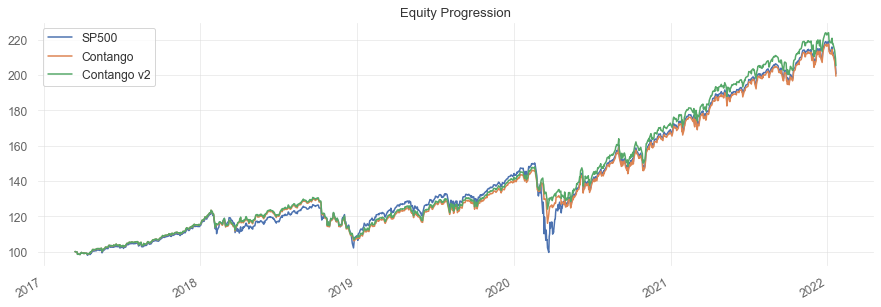

In [147]:
res.plot()

#### VRatio

In [153]:
signals_VRatio = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_VRatio=signals_VRatio*0
signals_VRatio['LQD'] = False
signals_VRatio['IEF'] = np.where(df['VRatio'] > 1.0, False, True)
signals_VRatio['GLD'] = np.where(df['VRatio'] > 1.0, False, True)
signals_VRatio['SPY'] = np.where(df['VRatio'] > 1.0, True, False)

#### Contango Roll

In [154]:
signals_CR = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_CR=signals_CR*0
signals_CR['LQD'] = False
signals_CR['IEF'] = np.where(df['ContangoRoll'] > .1, False, True)
signals_CR['GLD'] = np.where(df['ContangoRoll'] > .1, False, True)
signals_CR['SPY'] = np.where(df['ContangoRoll'] > .1, True, False)

#### Volatility Risk Premium

In [155]:
signals_VRP = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_VRP=signals_VRP*0
signals_VRP['LQD'] = False
signals_VRP['IEF'] = np.where(df['VRP10'] > 0.0, False, True)
signals_VRP['GLD'] = np.where(df['VRP10'] > 0.0, False, True)
signals_VRP['SPY'] = np.where(df['VRP10'] > 0.0, True, False)

#### Fast Volatility Risk Premium

In [156]:
signals_FVRP = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_FVRP=signals_FVRP*0
signals_FVRP['LQD'] = False
signals_FVRP['IEF'] = np.where(df['FVRP'] > 0.0, False, True)
signals_FVRP['GLD'] = np.where(df['FVRP'] > 0.0, False, True)
signals_FVRP['SPY'] = np.where(df['FVRP'] > 0.0, True, False)

#### Volatility Momentum

In [157]:
signals_VM = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_VM=signals_VM*0
signals_VM['LQD'] = False
signals_VM['IEF'] = np.where(df['VOLMOM'] > 0.0, False, True)
signals_VM['GLD'] = np.where(df['VOLMOM'] > 0.0, False, True)
signals_VM['SPY'] = np.where(df['VOLMOM'] > 0.0, True, False)

#### VIX Mean Reversion

In [159]:
signals_MRVIX = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_MRVIX=signals_MRVIX*0
signals_MRVIX['LQD'] = False
signals_MRVIX['IEF'] = np.where(df['MRVIX'], False, True)
signals_MRVIX['GLD'] = np.where(df['MRVIX'], False, True)
signals_MRVIX['SPY'] = np.where(df['MRVIX'], True, False)

#### VIX3M Mean Reversion

In [160]:
signals_MRVIX3M = df[['GLD', 'IEF', 'LQD', 'SPY']].copy(deep=True)
signals_MRVIX3M=signals_MRVIX3M*0
signals_MRVIX3M['LQD'] = False
signals_MRVIX3M['IEF'] = np.where(df['MRVIX3M'], False, True)
signals_MRVIX3M['GLD'] = np.where(df['MRVIX3M'], False, True)
signals_MRVIX3M['SPY'] = np.where(df['MRVIX3M'], True, False)

### Testing all signals separately

In [166]:
strat_dict = {'SP500': signals_df2, 'VRatio':signals_VRatio, 'Contango':signals_df3, 'ContangoRoll':signals_CR, 
              'VRP': signals_VRP, 'FVRP': signals_FVRP, 'VOLMOM': signals_VM, 'MRVIX': signals_MRVIX, 
              'MRVIX3M': signals_MRVIX3M}

all_bt = []

for key, signal_df in strat_dict.items():
    tmpStrat = bt.Strategy(key, [bt.algos.SelectWhere(signal_df),
                      bt.algos.WeighEqually(),
                      bt.algos.Rebalance()])
    all_bt.append(bt.Backtest(tmpStrat, df))

res = bt.run(*all_bt)

In [168]:
### Weird that MRVIX and MRVIX3M are so similar

res.display()

Stat                 SP500       VRatio      Contango    ContangoRoll    VRP         FVRP        VOLMOM      MRVIX       MRVIX3M
-------------------  ----------  ----------  ----------  --------------  ----------  ----------  ----------  ----------  ----------
Start                2017-03-15  2017-03-15  2017-03-15  2017-03-15      2017-03-15  2017-03-15  2017-03-15  2017-03-15  2017-03-15
End                  2022-01-21  2022-01-21  2022-01-21  2022-01-21      2022-01-21  2022-01-21  2022-01-21  2022-01-21  2022-01-21
Risk-free rate       0.00%       0.00%       0.00%       0.00%           0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         100.65%     104.81%     105.23%     108.02%         54.19%      63.05%      108.22%     49.29%      49.29%
Daily Sharpe         0.84        1.19        1.14        1.62            1.08        1.08        1.52        1.05        1.05
Daily Sortino        1.25        1.80        1.70        2.61            1.74        1.69    

<AxesSubplot:title={'center':'Equity Progression'}>

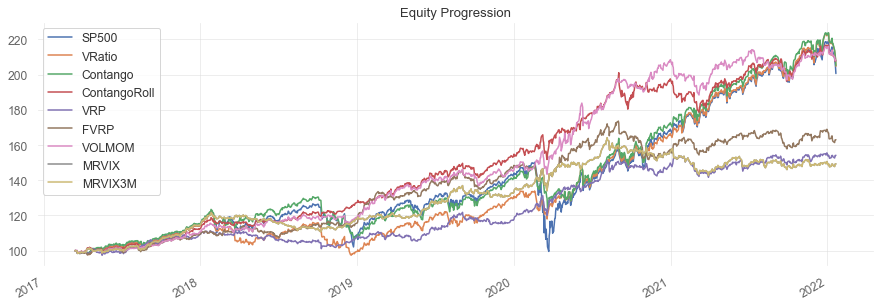

In [169]:
res.plot()

### Smoothing
Only consider a signal if t and t-1 have the same value.

In [176]:
strat_dict2 = {}

for key, signal_df in strat_dict.items():
    strat_dict2[key] = signal_df.multiply(signal_df.shift())

In [177]:
all_bt2 = []

for key, signal_df in strat_dict2.items():
    tmpStrat = bt.Strategy(key, [bt.algos.SelectWhere(signal_df),
                      bt.algos.WeighEqually(),
                      bt.algos.Rebalance()])
    all_bt2.append(bt.Backtest(tmpStrat, df))

res2 = bt.run(*all_bt2)

In [178]:
res2.display()

Stat                 SP500       VRatio      Contango    ContangoRoll    VRP         FVRP        VOLMOM      MRVIX       MRVIX3M
-------------------  ----------  ----------  ----------  --------------  ----------  ----------  ----------  ----------  ----------
Start                2017-03-15  2017-03-15  2017-03-15  2017-03-15      2017-03-15  2017-03-15  2017-03-15  2017-03-15  2017-03-15
End                  2022-01-21  2022-01-21  2022-01-21  2022-01-21      2022-01-21  2022-01-21  2022-01-21  2022-01-21  2022-01-21
Risk-free rate       0.00%       0.00%       0.00%       0.00%           0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         101.00%     100.01%     113.36%     79.35%          41.50%      42.09%      112.60%     45.00%      45.00%
Daily Sharpe         0.85        1.18        1.23        1.36            0.90        0.89        1.67        0.99        0.99
Daily Sortino        1.26        1.78        1.85        2.13            1.41        1.34    

<AxesSubplot:title={'center':'Equity Progression'}>

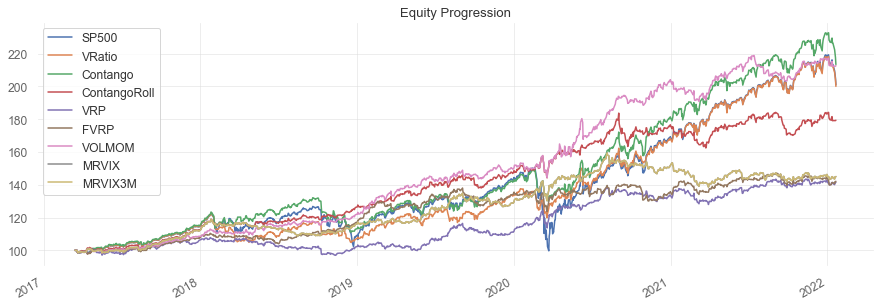

In [179]:
res2.plot()

### Combining signals
Combine two signals

In [186]:
signals_CxVM = signals_df3 & signals_VM

In [190]:
s_CxVM = bt.Strategy('CxVM', [bt.algos.SelectWhere(signals_CxVM),
                  bt.algos.WeighEqually(),
                  bt.algos.Rebalance()])
t_CxVM = bt.Backtest(s_CxVM, df)

res = bt.run(t_CxVM)

In [191]:
res.display()

Stat                 CxVM
-------------------  ----------
Start                2017-03-15
End                  2022-01-21
Risk-free rate       0.00%

Total Return         77.78%
Daily Sharpe         1.34
Daily Sortino        2.01
CAGR                 12.58%
Max Drawdown         -8.47%
Calmar Ratio         1.49

MTD                  -2.79%
3m                   -0.18%
6m                   0.25%
YTD                  -2.79%
1Y                   4.02%
3Y (ann.)            14.48%
5Y (ann.)            12.58%
10Y (ann.)           -
Since Incep. (ann.)  12.58%

Daily Sharpe         1.34
Daily Sortino        2.01
Daily Mean (ann.)    12.28%
Daily Vol (ann.)     9.16%
Daily Skew           -1.09
Daily Kurt           13.18
Best Day             3.05%
Worst Day            -5.76%

Monthly Sharpe       1.58
Monthly Sortino      4.72
Monthly Mean (ann.)  12.49%
Monthly Vol (ann.)   7.92%
Monthly Skew         0.60
Monthly Kurt         -0.12
Best Month           6.98%
Worst Month          -2.79%

Yearly S

<AxesSubplot:title={'center':'Equity Progression'}>

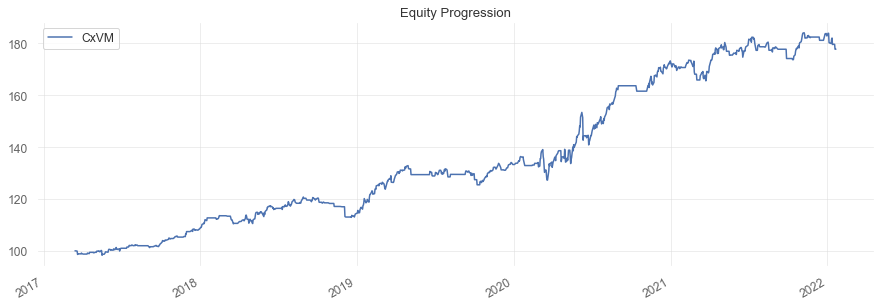

In [192]:
res.plot()

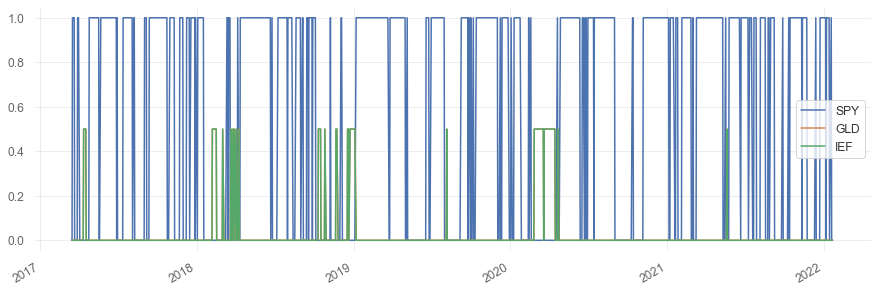

In [193]:
res.plot_security_weights()